In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load the actual data from the Excel file
actual_data = pd.read_excel("../../DATAFORMODELtrain200824.xlsx")

# Convert 'Date' to datetime format and round to the nearest hour
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M').dt.round('h')

In [4]:
# Define the date range
start_date = pd.to_datetime('2017-01-01 00:00')
cutoff_date = pd.to_datetime("2024-08-20 23:00")

In [5]:
# Filter data within the date range and drop unnecessary columns
columns_to_drop = [
    'Y', 'M', 'Day', 'H', 'Y2016',	'Y2017',	'Y2018',	'Y2019',	'Y2020',	'Y2021',	'Y2022',	'Y2023',	'Y2024',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12',
    'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
    'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
    'h20', 'h21', 'h22', 'h23', 'h24',
    'PriceCZ', 'PriceSK', 'PriceRO', 'WDAY'
]
data = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= cutoff_date)].drop(columns=columns_to_drop)


In [6]:
def check_NaN(data):
    # Select only numeric columns for spline interpolation
    numeric_columns = data.select_dtypes(include=[np.number]).columns

    print("Number of NaN values:\n", data[numeric_columns].isna().sum())

In [7]:
check_NaN(data)

Number of NaN values:
 PriceHU         0
PMIHU           0
GAS             0
COAL            0
CO2             0
COALTOGAS       0
DOFFHU          0
DOFFSK          0
DOFFRO          0
WND             0
T2MALL          0
T2MALLMAX       0
T2MALLMIN       0
T2MALLAV        0
T2MALLNONLIN    0
T2MALLP         0
T2MALLPCO2      0
T2MALLPROR      0
T2MHUNORM       0
THUDEVNORM      0
T2MHUPSQ        0
T2MHUP          0
T2MHU           0
PRECHU          0
WS10MHU         0
ALLSKY1HU       0
T2MSKPSQ        0
T2MSKP          0
T2MSK           0
PRECSK          0
WS10MSK         0
ALLSKY1SK       0
T2MROPSQ        0
T2MROP          0
T2MRO           0
PRECRO          0
WS10MRO         0
ALLSKY1RO       0
UNAVNUCHU       0
UNAVGASHU       0
UNAVLIGNHU      0
UNAVTPPHU       0
UNAVNUCSK       0
UNAVGASSK       0
UNAVLIGNSK      0
UNAVTPPSK       0
UNAVHYDRSK      0
UNAVNUCRO       0
UNAVGASRO       0
UNAVLIGNRO      0
UNAVTPPRO       0
UNAVHYDRRO      0
UNAVNUCCZ       0
UNAVGASCZ       0
UNAVL

In [8]:
# Feature Engineering - Date Features
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['Date'].dt.month

In [9]:
check_NaN(data)

Number of NaN values:
 PriceHU         0
PMIHU           0
GAS             0
COAL            0
CO2             0
COALTOGAS       0
DOFFHU          0
DOFFSK          0
DOFFRO          0
WND             0
T2MALL          0
T2MALLMAX       0
T2MALLMIN       0
T2MALLAV        0
T2MALLNONLIN    0
T2MALLP         0
T2MALLPCO2      0
T2MALLPROR      0
T2MHUNORM       0
THUDEVNORM      0
T2MHUPSQ        0
T2MHUP          0
T2MHU           0
PRECHU          0
WS10MHU         0
ALLSKY1HU       0
T2MSKPSQ        0
T2MSKP          0
T2MSK           0
PRECSK          0
WS10MSK         0
ALLSKY1SK       0
T2MROPSQ        0
T2MROP          0
T2MRO           0
PRECRO          0
WS10MRO         0
ALLSKY1RO       0
UNAVNUCHU       0
UNAVGASHU       0
UNAVLIGNHU      0
UNAVTPPHU       0
UNAVNUCSK       0
UNAVGASSK       0
UNAVLIGNSK      0
UNAVTPPSK       0
UNAVHYDRSK      0
UNAVNUCRO       0
UNAVGASRO       0
UNAVLIGNRO      0
UNAVTPPRO       0
UNAVHYDRRO      0
UNAVNUCCZ       0
UNAVGASCZ       0
UNAVL

In [10]:
# Lagged Features
lagged_features = [1, 2, 3, 6, 12, 24]
for lag in lagged_features:
    data[f'lag_{lag}'] = data['PriceHU'].shift(lag)
print("Lagged features created.")

Lagged features created.


In [11]:
data = data.dropna()

In [12]:
check_NaN(data)

Number of NaN values:
 PriceHU         0
PMIHU           0
GAS             0
COAL            0
CO2             0
COALTOGAS       0
DOFFHU          0
DOFFSK          0
DOFFRO          0
WND             0
T2MALL          0
T2MALLMAX       0
T2MALLMIN       0
T2MALLAV        0
T2MALLNONLIN    0
T2MALLP         0
T2MALLPCO2      0
T2MALLPROR      0
T2MHUNORM       0
THUDEVNORM      0
T2MHUPSQ        0
T2MHUP          0
T2MHU           0
PRECHU          0
WS10MHU         0
ALLSKY1HU       0
T2MSKPSQ        0
T2MSKP          0
T2MSK           0
PRECSK          0
WS10MSK         0
ALLSKY1SK       0
T2MROPSQ        0
T2MROP          0
T2MRO           0
PRECRO          0
WS10MRO         0
ALLSKY1RO       0
UNAVNUCHU       0
UNAVGASHU       0
UNAVLIGNHU      0
UNAVTPPHU       0
UNAVNUCSK       0
UNAVGASSK       0
UNAVLIGNSK      0
UNAVTPPSK       0
UNAVHYDRSK      0
UNAVNUCRO       0
UNAVGASRO       0
UNAVLIGNRO      0
UNAVTPPRO       0
UNAVHYDRRO      0
UNAVNUCCZ       0
UNAVGASCZ       0
UNAVL

In [13]:
# Rolling Statistics (Keep only important ones)
rolling_windows = [3, 12, 24, 36, 48, 7 * 24]
for window in rolling_windows:
    data[f'rolling_mean_{window}h'] = data['PriceHU'].rolling(window=window).mean()
    data[f'rolling_std_{window}h'] = data['PriceHU'].rolling(window=window).std()


In [14]:
data = data.dropna()

In [15]:
check_NaN(data)

Number of NaN values:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPPHU            0
UNAVNUCSK  

In [16]:
# Exponentially Weighted Moving Averages
ewm_windows = [3, 12, 24]
for span in ewm_windows:
    data[f'ewm_{span}h'] = data['PriceHU'].ewm(span=span).mean()

In [17]:
check_NaN(data)

Number of NaN values:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPPHU            0
UNAVNUCSK  

In [18]:
# FFT Features (Keep only the top frequencies)
fft_vals = fft(data['PriceHU'].fillna(0).values)  # Handle NaN with fillna
fft_magnitude = np.abs(fft_vals)
N = 3  # Reduce the number of frequencies to keep to avoid feature explosion
top_frequencies = np.argsort(fft_magnitude)[-N:]

for i, freq_idx in enumerate(top_frequencies):
    data[f'fft_magnitude_{i+1}'] = fft_magnitude[freq_idx]
print("FFT features created.")

FFT features created.


In [19]:
check_NaN(data)

Number of NaN values:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPPHU            0
UNAVNUCSK  

In [20]:
# Define feature matrix X and target y
X = data.drop(['PriceHU', 'Date'], axis=1)
y = data['PriceHU']


In [21]:
# Feature Importance using RandomForest and Mutual Information
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

In [22]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual information scores calculated.")
mi_scores

Mutual information scores calculated.


ewm_3h               2.038581
rolling_mean_3h      1.856420
lag_1                1.766263
lag_2                1.202954
ewm_12h              1.135916
lag_24               1.037634
ewm_24h              0.974755
lag_3                0.910155
rolling_mean_24h     0.903222
GAS                  0.900016
rolling_mean_12h     0.895678
COAL                 0.883443
rolling_mean_168h    0.853515
rolling_mean_36h     0.846798
rolling_mean_48h     0.834018
UNAVGASRO            0.787151
PMIHU                0.785193
COALTOGAS            0.756901
CO2                  0.736251
UNAVGASHU            0.691168
UNAVTPPBG            0.674739
rolling_std_168h     0.628681
UNAVTPPRO            0.621357
UNAVGASALL           0.615464
UNAVLIGNRO           0.608099
UNAVHYDRALL          0.600024
lag_12               0.585122
lag_6                0.578400
UNAVTPPHU            0.565628
UNAVTPPGR            0.555290
rolling_std_48h      0.548183
UNAVLIGNBG           0.547578
rolling_std_24h      0.537516
UNAVGASGR 

In [23]:
check_NaN(data)

Number of NaN values:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPPHU            0
UNAVNUCSK  

In [24]:
# Debugging: Check for duplicate labels
print("RF Importance Index Length:", len(rf_importances.index))
print("MI Scores Index Length:", len(mi_scores.index))
print("Unique RF Importance Index Length:", len(set(rf_importances.index)))
print("Unique MI Scores Index Length:", len(set(mi_scores.index)))

RF Importance Index Length: 129
MI Scores Index Length: 129
Unique RF Importance Index Length: 129
Unique MI Scores Index Length: 129


In [25]:
# Normalize and combine the scores
feature_scores = pd.DataFrame({'RF_Score': rf_importances, 'MI_Score': mi_scores})
feature_scores['CombinedScore'] = (feature_scores['RF_Score'] + feature_scores['MI_Score']).rank()
print("Feature scores combined.")

Feature scores combined.


In [26]:
# Select top features - Reduce to top 10-15
top_features = feature_scores.sort_values('CombinedScore', ascending=False).head(10).index.tolist()

In [27]:
top_features

['ewm_3h',
 'rolling_mean_3h',
 'lag_1',
 'lag_2',
 'ewm_12h',
 'lag_24',
 'ewm_24h',
 'lag_3',
 'rolling_mean_24h',
 'GAS']

In [28]:
# Generate Polynomial Features (Degree 2) only for top selected features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(data[top_features])
poly_feature_names = poly.get_feature_names_out(top_features)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

In [29]:
check_NaN(data)

Number of NaN values:
 PriceHU              0
PMIHU                0
GAS                  0
COAL                 0
CO2                  0
COALTOGAS            0
DOFFHU               0
DOFFSK               0
DOFFRO               0
WND                  0
T2MALL               0
T2MALLMAX            0
T2MALLMIN            0
T2MALLAV             0
T2MALLNONLIN         0
T2MALLP              0
T2MALLPCO2           0
T2MALLPROR           0
T2MHUNORM            0
THUDEVNORM           0
T2MHUPSQ             0
T2MHUP               0
T2MHU                0
PRECHU               0
WS10MHU              0
ALLSKY1HU            0
T2MSKPSQ             0
T2MSKP               0
T2MSK                0
PRECSK               0
WS10MSK              0
ALLSKY1SK            0
T2MROPSQ             0
T2MROP               0
T2MRO                0
PRECRO               0
WS10MRO              0
ALLSKY1RO            0
UNAVNUCHU            0
UNAVGASHU            0
UNAVLIGNHU           0
UNAVTPPHU            0
UNAVNUCSK  

In [30]:
check_NaN(poly_df)

Number of NaN values:
 ewm_3h                              0
rolling_mean_3h                     0
lag_1                               0
lag_2                               0
ewm_12h                             0
lag_24                              0
ewm_24h                             0
lag_3                               0
rolling_mean_24h                    0
GAS                                 0
ewm_3h^2                            0
ewm_3h rolling_mean_3h              0
ewm_3h lag_1                        0
ewm_3h lag_2                        0
ewm_3h ewm_12h                      0
ewm_3h lag_24                       0
ewm_3h ewm_24h                      0
ewm_3h lag_3                        0
ewm_3h rolling_mean_24h             0
ewm_3h GAS                          0
rolling_mean_3h^2                   0
rolling_mean_3h lag_1               0
rolling_mean_3h lag_2               0
rolling_mean_3h ewm_12h             0
rolling_mean_3h lag_24              0
rolling_mean_3h ewm_24h    

In [31]:
# Ensure that the indices of poly_df match those of the original data
poly_df.index = data.index

In [32]:
# Identify columns in poly_df that do not exist in data
new_columns = [col for col in poly_df.columns if col not in data.columns]
new_columns

['ewm_3h^2',
 'ewm_3h rolling_mean_3h',
 'ewm_3h lag_1',
 'ewm_3h lag_2',
 'ewm_3h ewm_12h',
 'ewm_3h lag_24',
 'ewm_3h ewm_24h',
 'ewm_3h lag_3',
 'ewm_3h rolling_mean_24h',
 'ewm_3h GAS',
 'rolling_mean_3h^2',
 'rolling_mean_3h lag_1',
 'rolling_mean_3h lag_2',
 'rolling_mean_3h ewm_12h',
 'rolling_mean_3h lag_24',
 'rolling_mean_3h ewm_24h',
 'rolling_mean_3h lag_3',
 'rolling_mean_3h rolling_mean_24h',
 'rolling_mean_3h GAS',
 'lag_1^2',
 'lag_1 lag_2',
 'lag_1 ewm_12h',
 'lag_1 lag_24',
 'lag_1 ewm_24h',
 'lag_1 lag_3',
 'lag_1 rolling_mean_24h',
 'lag_1 GAS',
 'lag_2^2',
 'lag_2 ewm_12h',
 'lag_2 lag_24',
 'lag_2 ewm_24h',
 'lag_2 lag_3',
 'lag_2 rolling_mean_24h',
 'lag_2 GAS',
 'ewm_12h^2',
 'ewm_12h lag_24',
 'ewm_12h ewm_24h',
 'ewm_12h lag_3',
 'ewm_12h rolling_mean_24h',
 'ewm_12h GAS',
 'lag_24^2',
 'lag_24 ewm_24h',
 'lag_24 lag_3',
 'lag_24 rolling_mean_24h',
 'lag_24 GAS',
 'ewm_24h^2',
 'ewm_24h lag_3',
 'ewm_24h rolling_mean_24h',
 'ewm_24h GAS',
 'lag_3^2',
 'lag_3 r

In [101]:
data_backup = data.copy()

In [100]:
# data = data_backup.copy()

In [102]:
# Only add the unique columns from poly_df to data
data = pd.concat([data, poly_df[new_columns]], axis=1)

In [103]:
check_NaN(data)

Number of NaN values:
 PriceHU                             0
PMIHU                               0
GAS                                 0
COAL                                0
CO2                                 0
COALTOGAS                           0
DOFFHU                              0
DOFFSK                              0
DOFFRO                              0
WND                                 0
T2MALL                              0
T2MALLMAX                           0
T2MALLMIN                           0
T2MALLAV                            0
T2MALLNONLIN                        0
T2MALLP                             0
T2MALLPCO2                          0
T2MALLPROR                          0
T2MHUNORM                           0
THUDEVNORM                          0
T2MHUPSQ                            0
T2MHUP                              0
T2MHU                               0
PRECHU                              0
WS10MHU                             0
ALLSKY1HU                  

In [104]:
# Remove Multicollinear Features
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.9)]
selected_features = list(set(data.columns) - set(highly_correlated) - {'PriceHU', 'Date'})

In [105]:
# Append 'PriceHU' and 'Date' to selected_features list
selected_features.extend(['PriceHU', 'Date'])

In [106]:
selected_features

['UNAVNUCSL',
 'UNAVLIGNBG',
 'UNAVNUCCZ',
 'SOLMAX',
 'HIGHTEMIMP',
 'rolling_std_24h',
 'RORRO',
 'ATWINDGEN',
 'RORSE_HP',
 'PRECHU',
 'DOFFSK',
 'ALLSKY1HU',
 'PMIHU',
 'COALTOGAS',
 'UNAVHYDRBG',
 'rolling_std_12h',
 'PRECSK',
 'UNAVHYDRSL',
 'UNAVTPPCZ',
 'UA_HU',
 'HIGHIMIMP',
 'UNAVGASSK',
 'UNAVHYDRFR',
 'THUDEVNORM',
 'T2MALL',
 'UNAVNUCFR',
 'UA_SK',
 'UNAVLIGNRO',
 'month',
 'UNAVLIGNHU',
 'lag_12',
 'DOFFHU',
 'WS10MSK',
 'UNAVGASCZ',
 'UNAVGASALL',
 'UNAVHYDRRO',
 'UADEM',
 'UNAVGASBG',
 'UNAVLIGNSK',
 'UNAVNUCSK',
 'RORSE',
 'day_of_week',
 'UNAVLIGNCZ',
 'UNAVNUCBG',
 'UNAVGASGR',
 'GAS',
 'WS10MHU',
 'WS10MRO',
 'AT_HU',
 'UA_RO',
 'BGSOLGEN',
 'rolling_std_3h',
 'PRECRO',
 'fft_magnitude_2',
 'RORAT_HP',
 'UNAVTPPGR',
 'UNAVHYDRSK',
 'ROSOLGEN',
 'UNAVTPPSK',
 'UNAVGASRO',
 'UNAVNUCRO',
 'UNAVGASSL',
 'PL_SK',
 'HUSOLGEN',
 'T2MALLPCO2',
 'DOFFRO',
 'T2MALLPROR',
 'fft_magnitude_3',
 'DEWINDGEN',
 'WND',
 'RORDE',
 'UNAVHYDRGR',
 'UNAVLIGNSL',
 'UNAVGASHU',
 'fft_magn

In [107]:
check_NaN(data[selected_features])

Number of NaN values:
 UNAVNUCSL          0
UNAVLIGNBG         0
UNAVNUCCZ          0
SOLMAX             0
HIGHTEMIMP         0
rolling_std_24h    0
RORRO              0
ATWINDGEN          0
RORSE_HP           0
PRECHU             0
DOFFSK             0
ALLSKY1HU          0
PMIHU              0
COALTOGAS          0
UNAVHYDRBG         0
rolling_std_12h    0
PRECSK             0
UNAVHYDRSL         0
UNAVTPPCZ          0
UA_HU              0
HIGHIMIMP          0
UNAVGASSK          0
UNAVHYDRFR         0
THUDEVNORM         0
T2MALL             0
UNAVNUCFR          0
UA_SK              0
UNAVLIGNRO         0
month              0
UNAVLIGNHU         0
lag_12             0
DOFFHU             0
WS10MSK            0
UNAVGASCZ          0
UNAVGASALL         0
UNAVHYDRRO         0
UADEM              0
UNAVGASBG          0
UNAVLIGNSK         0
UNAVNUCSK          0
RORSE              0
day_of_week        0
UNAVLIGNCZ         0
UNAVNUCBG          0
UNAVGASGR          0
GAS                0
WS10MHU    

In [108]:
# Drop rows with NaN values (or you could choose to impute them)
data_cleaned = data[selected_features].dropna()

In [109]:
check_NaN(data_cleaned)

Number of NaN values:
 UNAVNUCSL          0
UNAVLIGNBG         0
UNAVNUCCZ          0
SOLMAX             0
HIGHTEMIMP         0
rolling_std_24h    0
RORRO              0
ATWINDGEN          0
RORSE_HP           0
PRECHU             0
DOFFSK             0
ALLSKY1HU          0
PMIHU              0
COALTOGAS          0
UNAVHYDRBG         0
rolling_std_12h    0
PRECSK             0
UNAVHYDRSL         0
UNAVTPPCZ          0
UA_HU              0
HIGHIMIMP          0
UNAVGASSK          0
UNAVHYDRFR         0
THUDEVNORM         0
T2MALL             0
UNAVNUCFR          0
UA_SK              0
UNAVLIGNRO         0
month              0
UNAVLIGNHU         0
lag_12             0
DOFFHU             0
WS10MSK            0
UNAVGASCZ          0
UNAVGASALL         0
UNAVHYDRRO         0
UADEM              0
UNAVGASBG          0
UNAVLIGNSK         0
UNAVNUCSK          0
RORSE              0
day_of_week        0
UNAVLIGNCZ         0
UNAVNUCBG          0
UNAVGASGR          0
GAS                0
WS10MHU    

In [110]:
# Separate the features for PCA and the columns to retain
features_for_pca = data_cleaned.drop(['Date', 'PriceHU'], axis=1)

In [111]:
# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(features_for_pca)
print("Data standardized.")

Data standardized.


In [112]:
# Apply PCA to determine the number of components explaining 95% of the variance
pca_full = PCA().fit(data_standardized)
explained_variances = np.cumsum(pca_full.explained_variance_ratio_)

# Find the optimal number of components
best_n_components = np.argmax(explained_variances >= 0.95) + 1
print(f"Number of PCA components explaining at least 90% of variance: {best_n_components}")

Number of PCA components explaining at least 90% of variance: 49


In [113]:
# Apply PCA with the determined number of components
pca = PCA(n_components=best_n_components)
pca_components = pca.fit_transform(data_standardized)
print(f"PCA applied to reduce dimensionality to {pca.n_components} components.")

PCA applied to reduce dimensionality to 49 components.


In [114]:
# Create a DataFrame for PCA components
pca_columns = [f'PCA_{i+1}' for i in range(pca_components.shape[1])]
pca_df = pd.DataFrame(pca_components, columns=pca_columns, index=data_cleaned.index)
print("PCA components DataFrame created.")

PCA components DataFrame created.


In [115]:
# # Ensure that indices are aligned before merging back
# data_cleaned = data_cleaned.loc[pca_df.index]  # Align indices

In [116]:
# data_cleaned.head()

In [117]:
# Align indices and concatenate only the new PCA columns
data_for_prophet = pd.concat([data_cleaned[['Date', 'PriceHU']], pca_df], axis=1)
data_for_prophet = data_for_prophet.rename(columns={'Date': 'ds', 'PriceHU': 'y'})
print("Data prepared for Prophet with PCA components as regressors.")

Data prepared for Prophet with PCA components as regressors.


In [118]:
# Print Final Selected Features
print("Final PCA Components for Prophet Regressors:", pca_columns)

Final PCA Components for Prophet Regressors: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22', 'PCA_23', 'PCA_24', 'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_29', 'PCA_30', 'PCA_31', 'PCA_32', 'PCA_33', 'PCA_34', 'PCA_35', 'PCA_36', 'PCA_37', 'PCA_38', 'PCA_39', 'PCA_40', 'PCA_41', 'PCA_42', 'PCA_43', 'PCA_44', 'PCA_45', 'PCA_46', 'PCA_47', 'PCA_48', 'PCA_49']


In [119]:
check_NaN(data_for_prophet)

Number of NaN values:
 y         0
PCA_1     0
PCA_2     0
PCA_3     0
PCA_4     0
PCA_5     0
PCA_6     0
PCA_7     0
PCA_8     0
PCA_9     0
PCA_10    0
PCA_11    0
PCA_12    0
PCA_13    0
PCA_14    0
PCA_15    0
PCA_16    0
PCA_17    0
PCA_18    0
PCA_19    0
PCA_20    0
PCA_21    0
PCA_22    0
PCA_23    0
PCA_24    0
PCA_25    0
PCA_26    0
PCA_27    0
PCA_28    0
PCA_29    0
PCA_30    0
PCA_31    0
PCA_32    0
PCA_33    0
PCA_34    0
PCA_35    0
PCA_36    0
PCA_37    0
PCA_38    0
PCA_39    0
PCA_40    0
PCA_41    0
PCA_42    0
PCA_43    0
PCA_44    0
PCA_45    0
PCA_46    0
PCA_47    0
PCA_48    0
PCA_49    0
dtype: int64


In [120]:
# Extract 'is_weekend' and 'Date' from the original data
is_weekend_data = data[['Date', 'is_weekend']]

# Load the prepared data
prepared_data = data_for_prophet.copy()

# Ensure 'ds' in prepared data is in datetime format
prepared_data['ds'] = pd.to_datetime(prepared_data['ds'], errors='coerce')

# Merge 'is_weekend' with prepared data using the date columns
prepared_data = pd.merge(prepared_data, is_weekend_data, left_on='ds', right_on='Date', how='left')

# Drop the extra 'Date' column that was added during the merge
prepared_data = prepared_data.drop(columns=['Date'])

In [121]:
prepared_data.head()

,ds,y,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,is_weekend
0,2017-01-08 23:00:00,57.69,-3.500899,-3.849222,0.054942,-1.080438,0.311205,-0.021461,1.086178,0.462453,-1.001287,-1.895561,2.781428,-0.903040,-0.926026,-0.470969,-0.106664,-0.745067,0.649439,1.639419,0.628378,0.466675,-0.106287,0.255243,1.387958,-0.825232,-0.499367,0.133845,1.376966,-0.462849,0.964027,0.672457,-0.352923,-0.930140,-1.949153,-0.968096,0.985538,-0.810262,0.046397,0.152113,0.182916,0.279561,0.223990,1.427545,-0.942344,0.898234,-0.825769,0.556007,0.291354,-0.504105,0.025805,1
1,2017-01-09 00:00:00,46.37,-3.373880,-4.079514,-0.076742,-1.206125,0.634102,0.503755,1.149341,-1.624341,-2.245985,-1.295650,0.763270,-1.109066,0.546305,-0.705583,-1.899383,-0.279849,-0.371429,1.737718,0.678170,-0.852767,0.322668,0.403238,0.477704,-0.233077,-0.172806,-0.077509,1.040915,-0.070386,1.246826,0.490539,-0.789656,-0.409156,-1.995456,-0.774577,0.448947,-0.112344,-0.415213,0.256543,0.128817,-0.068079,0.485991,1.613608,-0.648830,0.898721,-0.928362,-0.302032,0.223039,-0.203902,-0.151345,0
2,2017-01-09 01:00:00,40.36,-3.104195,-4.229536,-0.192779,-0.908272,0.361461,0.435616,1.085567,-1.371830,-2.436302,-1.504189,0.566296,-1.022526,0.473311,-0.707023,-2.075682,-0.346817,-0.374505,1.799001,0.480499,-0.765888,0.477862,0.861274,0.422095,-0.311878,0.077945,-0.077746,1.495125,-0.163143,1.223220,0.506898,-0.710657,-0.707126,-2.136980,-0.865388,0.696600,-0.111431,-0.725690,0.315691,0.021568,-0.136653,0.586138,1.844306,-0.599709,0.854896,-0.975132,-0.113901,0.144050,-0.118511,-0.292562,0
3,2017-01-09 02:00:00,38.38,-3.017387,-4.293118,-0.165006,-0.880147,0.300313,0.589734,1.187115,-1.347719,-2.463348,-1.507617,0.562233,-1.170715,0.596580,-0.666272,-2.024185,-0.343897,-0.419471,1.770775,0.283725,-0.702140,0.570587,0.856460,0.424144,-0.403840,-0.008675,-0.153428,1.537586,-0.165392,1.257919,0.376899,-0.647460,-0.822054,-1.974038,-0.869233,0.855145,-0.156990,-0.722860,0.338889,0.087263,-0.168573,0.477764,1.729494,-0.610203,0.887549,-0.983600,0.061918,-0.030498,-0.464482,-0.192013,0
4,2017-01-09 03:00:00,38.55,-3.043014,-4.246697,-0.063790,-0.825442,0.300433,0.607965,1.172028,-1.328849,-2.498056,-1.541454,0.504417,-1.165511,0.538187,-0.640492,-1.956903,-0.368267,-0.387922,1.756728,0.280551,-0.588869,0.597052,0.799595,0.414893,-0.456556,-0.000715,-0.163510,1.592352,-0.128822,1.301504,0.339818,-0.614848,-0.818841,-1.921808,-0.825003,0.922029,-0.103255,-0.748497,0.319385,0.038401,-0.136622,0.346480,1.709363,-0.725822,0.862034,-0.948109,0.152502,-0.026180,-0.490790,-0.157862,0


In [122]:
check_NaN(prepared_data)

Number of NaN values:
 y             0
PCA_1         0
PCA_2         0
PCA_3         0
PCA_4         0
PCA_5         0
PCA_6         0
PCA_7         0
PCA_8         0
PCA_9         0
PCA_10        0
PCA_11        0
PCA_12        0
PCA_13        0
PCA_14        0
PCA_15        0
PCA_16        0
PCA_17        0
PCA_18        0
PCA_19        0
PCA_20        0
PCA_21        0
PCA_22        0
PCA_23        0
PCA_24        0
PCA_25        0
PCA_26        0
PCA_27        0
PCA_28        0
PCA_29        0
PCA_30        0
PCA_31        0
PCA_32        0
PCA_33        0
PCA_34        0
PCA_35        0
PCA_36        0
PCA_37        0
PCA_38        0
PCA_39        0
PCA_40        0
PCA_41        0
PCA_42        0
PCA_43        0
PCA_44        0
PCA_45        0
PCA_46        0
PCA_47        0
PCA_48        0
PCA_49        0
is_weekend    0
dtype: int64


In [123]:
# Export Data for Prophet
prepared_data.to_csv('prepared_data_for_prophet.csv', index=False)
print("Data exported to 'prepared_data_for_prophet.csv'.")

Data exported to 'prepared_data_for_prophet.csv'.


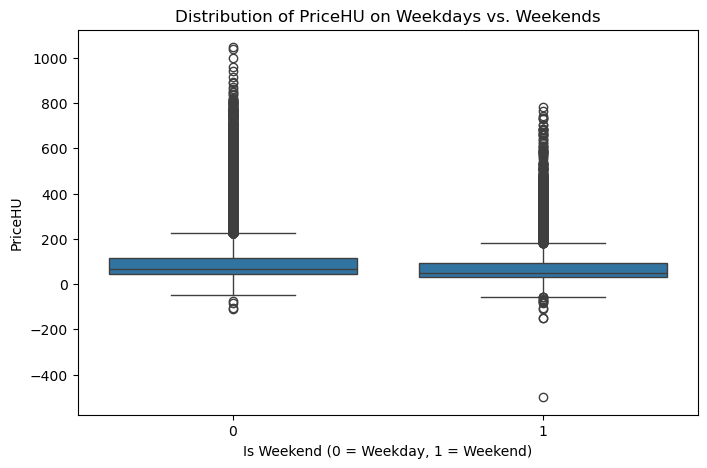

In [170]:
# Plot the average PriceHU for weekdays and weekends
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_weekend', y='PriceHU', data=data)
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('PriceHU')
plt.title('Distribution of PriceHU on Weekdays vs. Weekends')
plt.show()

In [171]:
# Calculate the mean PriceHU for weekdays (is_weekend = 0) and weekends (is_weekend = 1)
mean_price_weekend = data.groupby('is_weekend')['PriceHU'].mean()

print("Average PriceHU for Weekdays (is_weekend = 0):", mean_price_weekend[0])
print("Average PriceHU for Weekends (is_weekend = 1):", mean_price_weekend[1])

Average PriceHU for Weekdays (is_weekend = 0): 103.99226576916625
Average PriceHU for Weekends (is_weekend = 1): 78.44598310332162


In [172]:
from scipy.stats import ttest_ind

# Separate data into weekends and weekdays
weekend_data = data[data['is_weekend'] == 1]['PriceHU']
weekday_data = data[data['is_weekend'] == 0]['PriceHU']

# Perform a two-sample t-test to check if the means are significantly different
t_stat, p_value = ttest_ind(weekend_data, weekday_data, nan_policy='omit')

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference in PriceHU between weekends and weekdays is statistically significant.")
else:
    print("The difference in PriceHU between weekends and weekdays is not statistically significant.")

T-statistic: -30.45505997547017
P-value: 2.5179063097233847e-202
The difference in PriceHU between weekends and weekdays is statistically significant.


In [173]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare the feature matrix X and target y
X = data[['is_weekend']]
y = data['PriceHU']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importance = rf_model.feature_importances_[0]

print(f"Feature Importance of 'is_weekend': {importance}")

if importance > 0.01:  # Threshold can be adjusted based on domain knowledge
    print("'is_weekend' is an important feature for predicting PriceHU.")
else:
    print("'is_weekend' does not significantly impact the prediction of PriceHU.")

Feature Importance of 'is_weekend': 1.0
'is_weekend' is an important feature for predicting PriceHU.


In [174]:
# Extract 'is_weekend' and 'Date' from the original data
is_weekend_data = data[['Date', 'is_weekend']]

# Load the prepared data
prepared_data = pd.read_csv("prepared_data_for_prophet.csv")

# Ensure 'ds' in prepared data is in datetime format
prepared_data['ds'] = pd.to_datetime(prepared_data['ds'], errors='coerce')

# Merge 'is_weekend' with prepared data using the date columns
prepared_data = pd.merge(prepared_data, is_weekend_data, left_on='ds', right_on='Date', how='left')

# Drop the extra 'Date' column that was added during the merge
prepared_data = prepared_data.drop(columns=['Date'])

# Save the updated data back to CSV
prepared_data.to_csv('prepared_data_for_prophet.csv', index=False)

In [176]:
# Sort by 'ds' in ascending order
prepared_data = prepared_data.sort_values(by='ds', ascending=True)

In [178]:
check_NaN(prepared_data)

Number of NaN values:
 y             8975
PCA_1         8975
PCA_2         8975
PCA_3         8975
PCA_4         8975
PCA_5         8975
is_weekend    8975
dtype: int64


In [177]:
prepared_data.head()

,ds,y,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,is_weekend
0,2017-01-08 23:00:00,57.69,-19730.418658,20523.828086,-19056.228537,13802.085761,-3089.571378,1.0
1,2017-01-09 00:00:00,46.37,-20764.377981,20095.408964,-18993.955976,13873.859300,-3012.524664,0.0
2,2017-01-09 01:00:00,40.36,-21361.097481,19527.503809,-18936.980887,13819.132053,-3016.169447,0.0
3,2017-01-09 02:00:00,38.38,-20670.507585,19947.930032,-18920.254799,13730.454836,-3058.845597,0.0
4,2017-01-09 03:00:00,38.55,-22632.668940,19326.838555,-18865.672695,14040.024173,-2897.408393,0.0
